# Assignment 1

The goal of this assignment is to supply you with machine learning models and algorithms. In this notebook, we will cover linear and nonlinear models, the concept of loss functions and some optimization techniques. All mathematical operations should be implemented in **NumPy** only. 


## Table of contents
* [1. Logistic Regression](#1.-Logistic-Regression)
    * [1.1 Linear Mapping](#1.1-Linear-Mapping)
    * [1.2 Sigmoid](#1.2-Sigmoid)
    * [1.3 Negative Log Likelihood](#1.3-Negative-Log-Likelihood)
    * [1.4 Model](#1.4-Model)
    * [1.5 Simple Experiment](#1.5-Simple-Experiment)
* [2. Decision Tree](#2.-Decision-Tree)
    * [2.1 Gini Index & Data Split](#2.1-Gini-Index-&-Data-Split)
    * [2.2 Terminal Node](#2.2-Terminal-Node)
    * [2.3 Build the Decision Tree](#2.3-Build-the-Decision-Tree)
* [3. Experiments](#3.-Experiments)
    * [3.1 Decision Tree for Heart Disease Prediction](#3.1-Decision-Tree-for-Heart-Disease-Prediction) 
    * [3.2 Logistic Regression for Heart Disease Prediction](#3.2-Logistic-Regression-for-Heart-Disease-Prediction)

### Note
Some of the concepts below have not (yet) been discussed during the lecture. These will be discussed further during the next lectures. 

### Before you begin

To check whether the code you've written is correct, we'll use **automark**. For this, we created for each of you an account with the username being your student number. 

In [166]:
import automark as am

# fill in you student number as your username
username = '10677186'

# to check your progress, you can run this function
am.get_progress(username)

---------------------------------------------
| Harm Manders                              |
| harmmanders@gmail.com                     |
---------------------------------------------
| W2: linear_forward       | completed      |
| W2: linear_grad_W        | completed      |
| W2: linear_grad_b        | completed      |
| W2: nll_forward          | completed      |
| W2: nll_grad_input       | completed      |
| W2: sigmoid_forward      | completed      |
| W2: sigmoid_grad_input   | completed      |
| W2: tree_gini_index      | not attempted  |
| W2: tree_split_data_left | not attempted  |
| W2: tree_split_data_right| not attempted  |
| W2: tree_to_terminal     | not attempted  |
| W3: box_blur             | not attempted  |
| W3: conv_matrix          | not attempted  |
| W3: dense_forward        | not attempted  |
| W3: dense_grad_W         | not attempted  |
| W3: dense_grad_b         | not attempted  |
| W3: dense_grad_input     | not attempted  |
| W3: flatten_forward      | not a

So far all your tests are 'not attempted'. At the end of this notebook you'll need to have completed all test. The output of `am.get_progress(username)` should at least match the example below. However, we encourage you to take a shot at the 'not attempted' tests!

```
---------------------------------------------
| Your name / student number                |
| your_email@your_domain.whatever           |
---------------------------------------------
| linear_forward           | not attempted  |
| linear_grad_W            | not attempted  |
| linear_grad_b            | not attempted  |
| nll_forward              | not attempted  |
| nll_grad_input           | not attempted  |
| sigmoid_forward          | not attempted  |
| sigmoid_grad_input       | not attempted  |
| tree_data_split_left     | not attempted  |
| tree_data_split_right    | not attempted  |
| tree_gini_index          | not attempted  |
| tree_to_terminal         | not attempted  |
---------------------------------------------
```

In [167]:
from __future__ import print_function, absolute_import, division # You don't need to know what this is. 
import numpy as np # this imports numpy, which is used for vector- and matrix calculations

In [168]:
import time
start = time.time()

In [176]:
def call30(f, args):
    global start
    ttw = 30 - (time.time() - start)
    if ttw > 0:
        print("Time to wait: {}s".format(round(ttw, 2)))
        time.sleep(ttw)
    f( *args )
    start = time.time()

This notebook makes use of **classes** and their **instances** that we have already implemented for you. It allows us to write less code and make it more readable. If you are interested in it, here are some useful links:
* The official [documentation](https://docs.python.org/3/tutorial/classes.html) 
* Video by *sentdex*: [Object Oriented Programming Introduction](https://www.youtube.com/watch?v=ekA6hvk-8H8)
* Antipatterns in OOP: [Stop Writing Classes](https://www.youtube.com/watch?v=o9pEzgHorH0)

# 1. Logistic Regression

We start with a very simple algorithm called **Logistic Regression**. It is a generalized linear model for 2-class classification.
It can be generalized to the case of many classes and to non-linear cases as well. However, here we consider only the simplest case. 

Let us consider a data with 2 classes. Class 0 and class 1. For a given test sample, logistic regression returns a value from $[0, 1]$ which is interpreted as a probability of belonging to class 1. The set of points for which the prediction is $0.5$ is called a *decision boundary*. It is a line on a plane or a hyper-plane in a space.

![](https://nlpforhackers.io/wp-content/uploads/2018/07/Linear-Separability-610x610.png)

Logistic regression has two trainable parameters: a weight $W$ and a bias $b$. For a vector of features $X$, the prediction of logistic regression is given by

$$
f(X) = \frac{1}{1 + \exp(-[XW + b])} = \sigma(h(X))
$$
where $\sigma(z) = \frac{1}{1 + \exp(-z)}$ and $h(X)=XW + b$.

Parameters $W$ and $b$ are fitted by maximizing the log-likelihood (or minimizing the negative log-likelihood) of the model on the training data. For a training subset $\{X_j, Y_j\}_{j=1}^N$ the normalized negative log likelihood (NLL) is given by 

$$
\mathcal{L} = -\frac{1}{N}\sum_j \log\Big[ f(X_j)^{Y_j} \cdot (1-f(X_j))^{1-Y_j}\Big]
= -\frac{1}{N}\sum_j \Big[ Y_j\log f(X_j) + (1-Y_j)\log(1-f(X_j))\Big]
$$

There are different ways of fitting this model. In this assignment we consider Logistic Regression as a one-layer neural network. We use the following algorithm for the **forward** pass:

1. Linear mapping: $h=XW + b$
2. Sigmoid activation function: $f=\sigma(h)$
3. Calculation of NLL: $\mathcal{L} = -\frac{1}{N}\sum_j \Big[ Y_j\log f_j + (1-Y_j)\log(1-f_j)\Big]$

In order to fit $W$ and $b$ we perform Gradient Descent ([GD](https://en.wikipedia.org/wiki/Gradient_descent)). We choose a small learning rate $\gamma$ and after each computation of forward pass, we update the parameters 

$$W_{\text{new}} = W_{\text{old}} - \gamma \frac{\partial \mathcal{L}}{\partial W}$$

$$b_{\text{new}} = b_{\text{old}} - \gamma \frac{\partial \mathcal{L}}{\partial b}$$

We use Backpropagation method ([BP](https://en.wikipedia.org/wiki/Backpropagation)) to calculate the partial derivatives of the loss function with respect to the parameters of the model.

$$
\frac{\partial\mathcal{L}}{\partial W} = 
\frac{\partial\mathcal{L}}{\partial h} \frac{\partial h}{\partial W} =
\frac{\partial\mathcal{L}}{\partial f} \frac{\partial f}{\partial h} \frac{\partial h}{\partial W}
$$

$$
\frac{\partial\mathcal{L}}{\partial b} = 
\frac{\partial\mathcal{L}}{\partial h} \frac{\partial h}{\partial b} =
\frac{\partial\mathcal{L}}{\partial f} \frac{\partial f}{\partial h} \frac{\partial h}{\partial b}
$$

## 1.1 Linear Mapping
First of all, you need to implement the forward pass of a linear mapping:
$$
h(X) = XW +b
$$

**Note**: here we use `n_out` as the dimensionality of the output. For logisitc regression `n_out = 1`. However, we will work with cases of `n_out > 1` in next assignments. You will **pass** the current assignment even if your implementation works only in case `n_out = 1`. If your implementation works for the cases of `n_out > 1` then you will not have to modify your method next week. All **numpy** operations are generic. It is recommended to use numpy when is it possible.

In [170]:
def linear_forward(x_input, W, b):
    """Perform the mapping of the input
    # Arguments
        x_input: input of the linear function - np.array of size `(n_objects, n_in)`
        W: np.array of size `(n_in, n_out)`
        b: np.array of size `(n_out,)`
    # Output
        the output of the linear function 
        np.array of size `(n_objects, n_out)`
    """
    return x_input @ W + b # @ is operator for matrix multiplication

Let's check your first function. We set the matrices $X, W, b$:
$$
X = \begin{bmatrix}
1 & -1 \\
-1 & 0 \\
1 & 1 \\
\end{bmatrix} \quad
W = \begin{bmatrix}
4 \\
2 \\
\end{bmatrix} \quad
b = \begin{bmatrix}
3 \\
\end{bmatrix}
$$

And then compute 
$$
XW = \begin{bmatrix}
1 & -1 \\
-1 & 0 \\
1 & 1 \\
\end{bmatrix}
\begin{bmatrix}
4 \\
2 \\
\end{bmatrix} =
\begin{bmatrix}
2 \\
-4 \\
6 \\
\end{bmatrix} \\
XW + b = 
\begin{bmatrix}
5 \\
-1 \\
9 \\
\end{bmatrix} 
$$

In [171]:
X_test = np.array([[1, -1],
                   [-1, 0],
                   [1, 1]])

W_test = np.array([[4],
                   [2]])

b_test = np.array([3])

h_test = linear_forward(X_test, W_test, b_test)
print(h_test)

[[ 5]
 [-1]
 [ 9]]


In [179]:
call30(am.test_student_function, (username, linear_forward, ['x_input', 'W', 'b']))

Time to wait: 26.79s
Running local tests...
linear_forward successfully passed local tests
Running remote test...
Test was successful. Congratulations!


Now you need to implement the calculation of the partial derivative of the loss function with respect to the parameters of the model. As this expressions are used for the updates of the parameters, we refer to them as gradients.
$$
\frac{\partial \mathcal{L}}{\partial W} = 
\frac{\partial \mathcal{L}}{\partial h}
\frac{\partial h}{\partial W} \\
\frac{\partial \mathcal{L}}{\partial b} = 
\frac{\partial \mathcal{L}}{\partial h}
\frac{\partial h}{\partial b} \\
$$

In [173]:
def linear_grad_W(x_input, grad_output, W, b):
    """Calculate the partial derivative of 
        the loss with respect to W parameter of the function
        dL / dW = (dL / dh) * (dh / dW)
    # Arguments
        x_input: input of a dense layer - np.array of size `(n_objects, n_in)`
        grad_output: partial derivative of the loss functions with 
            respect to the ouput of the dense layer (dL / dh)
            np.array of size `(n_objects, n_out)`
        W: np.array of size `(n_in, n_out)`
        b: np.array of size `(n_out,)`
    # Output
        the partial derivative of the loss 
        with respect to W parameter of the function
        np.array of size `(n_in, n_out)`
    """
    # dh/dW = X
    return x_input.T @ grad_output

In [180]:
call30(am.test_student_function, (username, linear_grad_W, ['x_input', 'grad_output', 'W', 'b']))

Running local tests...
linear_grad_W successfully passed local tests
Running remote test...
Test was successful. Congratulations!


In [ ]:
def linear_grad_b(x_input, grad_output, W, b):
    """Calculate the partial derivative of 
        the loss with respect to b parameter of the function
        dL / db = (dL / dh) * (dh / db)
    # Arguments
        x_input: input of a dense layer - np.array of size `(n_objects, n_in)`
        grad_output: partial derivative of the loss functions with 
            respect to the ouput of the linear function (dL / dh)
            np.array of size `(n_objects, n_out)`
        W: np.array of size `(n_in, n_out)`
        b: np.array of size `(n_out,)`
    # Output
        the partial derivative of the loss 
        with respect to b parameter of the linear function
        np.array of size `(n_out,)`
    """
    # dh/db = [1] * n_out
    return grad_output.T @ np.ones((np.shape(x_input)[0],))

In [181]:
call30(am.test_student_function, (username, linear_grad_b, ['x_input', 'grad_output', 'W', 'b']))

Time to wait: 15.5s
Running local tests...
linear_grad_b successfully passed local tests
Running remote test...
Test was successful. Congratulations!


In [182]:
am.get_progress(username)

---------------------------------------------
| Harm Manders                              |
| harmmanders@gmail.com                     |
---------------------------------------------
| W2: linear_forward       | completed      |
| W2: linear_grad_W        | completed      |
| W2: linear_grad_b        | completed      |
| W2: nll_forward          | completed      |
| W2: nll_grad_input       | completed      |
| W2: sigmoid_forward      | completed      |
| W2: sigmoid_grad_input   | completed      |
| W2: tree_gini_index      | not attempted  |
| W2: tree_split_data_left | not attempted  |
| W2: tree_split_data_right| not attempted  |
| W2: tree_to_terminal     | not attempted  |
| W3: box_blur             | not attempted  |
| W3: conv_matrix          | not attempted  |
| W3: dense_forward        | not attempted  |
| W3: dense_grad_W         | not attempted  |
| W3: dense_grad_b         | not attempted  |
| W3: dense_grad_input     | not attempted  |
| W3: flatten_forward      | not a

## 1.2 Sigmoid
$$
f = \sigma(h) = \frac{1}{1 + e^{-h}} 
$$

Sigmoid function is applied element-wise. It does not change the dimensionality of the tensor and its implementation is shape-agnostic in general.

In [183]:
def sigmoid_forward(x_input):
    """sigmoid nonlinearity
    # Arguments
        x_input: np.array of size `(n_objects, n_in)`
    # Output
        the output of relu layer
        np.array of size `(n_objects, n_in)`
    """
    return 1 / (1+np.exp(-x_input))

In [184]:
call30(am.test_student_function, (username, sigmoid_forward, ['x_input']))

Time to wait: 29.89s
Running local tests...
sigmoid_forward successfully passed local tests
Running remote test...
Test was successful. Congratulations!


Now you need to implement the calculation of the partial derivative of the loss function with respect to the input of sigmoid. 

$$
\frac{\partial \mathcal{L}}{\partial h} = 
\frac{\partial \mathcal{L}}{\partial f}
\frac{\partial f}{\partial h} 
$$

Tensor $\frac{\partial \mathcal{L}}{\partial f}$ comes from the loss function. Let's calculate $\frac{\partial f}{\partial h}$

$$
\frac{\partial f}{\partial h} = 
\frac{\partial \sigma(h)}{\partial h} =
\frac{\partial}{\partial h} \Big(\frac{1}{1 + e^{-h}}\Big)
= \frac{e^{-h}}{(1 + e^{-h})^2}
= \frac{1}{1 + e^{-h}} \frac{e^{-h}}{1 + e^{-h}}
= f(h) (1 - f(h))
$$

Therefore, in order to calculate the gradient of the loss with respect to the input of sigmoid function you need 
to 
1. calculate $f(h) (1 - f(h))$ 
2. multiply it element-wise by $\frac{\partial \mathcal{L}}{\partial f}$

In [ ]:
def sigmoid_grad_input(x_input, grad_output):
    """sigmoid nonlinearity gradient. 
        Calculate the partial derivative of the loss 
        with respect to the input of the layer
    # Arguments
        x_input: np.array of size `(n_objects, n_in)`
        grad_output: np.array of size `(n_objects, n_in)` 
            dL / df
    # Output
        the partial derivative of the loss 
        with respect to the input of the function
        np.array of size `(n_objects, n_in)` 
        dL / dh
    """
    return sigmoid_forward(x_input) * (1 - sigmoid_forward(x_input)) * grad_output

In [185]:
call30(am.test_student_function, (username, sigmoid_grad_input, ['x_input', 'grad_output']))

Time to wait: 29.99s
Running local tests...
sigmoid_grad_input successfully passed local tests
Running remote test...
Test was successful. Congratulations!


## 1.3 Negative Log Likelihood

$$
\mathcal{L} 
= -\frac{1}{N}\sum_j \Big[ Y_j\log \dot{Y}_j + (1-Y_j)\log(1-\dot{Y}_j)\Big]
$$

Here $N$ is the number of objects. $Y_j$ is the real label of an object and $\dot{Y}_j$ is the predicted one.

In [ ]:
def nll_forward(target_pred, target_true):
    """Compute the value of NLL
        for a given prediction and the ground truth
    # Arguments
        target_pred: predictions - np.array of size `(n_objects, 1)`
        target_true: ground truth - np.array of size `(n_objects, 1)`
    # Output
        the value of NLL for a given prediction and the ground truth
        scalar
    """  
    N = np.shape(target_pred)[0]
    s = np.sum(target_true * np.log(target_pred) + (1-target_true) * np.log(1-target_pred))
    return - 1 / N * s

In [186]:
call30(am.test_student_function, (username, nll_forward, ['target_pred', 'target_true']))

Time to wait: 29.99s
Running local tests...
nll_forward successfully passed local tests
Running remote test...
Test was successful. Congratulations!


Now you need to calculate the partial derivative of NLL with with respect to its input.

$$
\frac{\partial \mathcal{L}}{\partial \dot{Y}}
=
\begin{pmatrix}
\frac{\partial \mathcal{L}}{\partial \dot{Y}_0} \\
\frac{\partial \mathcal{L}}{\partial \dot{Y}_1} \\
\vdots \\
\frac{\partial \mathcal{L}}{\partial \dot{Y}_N}
\end{pmatrix}
$$

Let's do it step-by-step

\begin{equation}
\begin{split}
\frac{\partial \mathcal{L}}{\partial \dot{Y}_0} 
&= \frac{\partial}{\partial \dot{Y}_0} \Big(-\frac{1}{N}\sum_j \Big[ Y_j\log \dot{Y}_j + (1-Y_j)\log(1-\dot{Y}_j)\Big]\Big) \\
&= -\frac{1}{N} \frac{\partial}{\partial \dot{Y}_0} \Big(Y_0\log \dot{Y}_0 + (1-Y_0)\log(1-\dot{Y}_0)\Big) \\
&= -\frac{1}{N} \Big(\frac{Y_0}{\dot{Y}_0} - \frac{1-Y_0}{1-\dot{Y}_0}\Big)
= \frac{1}{N} \frac{\dot{Y}_0 - Y_0}{\dot{Y}_0 (1 - \dot{Y}_0)}
\end{split}
\end{equation}

And for the other components it can be done in exactly the same way. So the result is the vector where each component is given by 
$$\frac{1}{N} \frac{\dot{Y}_j - Y_j}{\dot{Y}_j (1 - \dot{Y}_j)}$$

Or if we assume all multiplications and divisions to be done element-wise the output can be calculated as
$$
\frac{\partial \mathcal{L}}{\partial \dot{Y}} = \frac{1}{N} \frac{\dot{Y} - Y}{\dot{Y} (1 - \dot{Y})}
$$

In [ ]:
def nll_grad_input(target_pred, target_true):
    """Compute the partial derivative of NLL
        with respect to its input
    # Arguments
        target_pred: predictions - np.array of size `(n_objects, 1)`
        target_true: ground truth - np.array of size `(n_objects, 1)`
    # Output
        the partial derivative 
        of NLL with respect to its input
        np.array of size `(n_objects, 1)`
    """
    N = np.shape(target_pred)[0]
    return 1 / N * (target_pred - target_true) / (target_pred * (1 - target_pred))

In [187]:
call30(am.test_student_function, (username, nll_grad_input, ['target_pred', 'target_true']))

Time to wait: 29.99s
Running local tests...
nll_grad_input successfully passed local tests
Running remote test...
Test was successful. Congratulations!


In [188]:
am.get_progress(username)

---------------------------------------------
| Harm Manders                              |
| harmmanders@gmail.com                     |
---------------------------------------------
| W2: linear_forward       | completed      |
| W2: linear_grad_W        | completed      |
| W2: linear_grad_b        | completed      |
| W2: nll_forward          | completed      |
| W2: nll_grad_input       | completed      |
| W2: sigmoid_forward      | completed      |
| W2: sigmoid_grad_input   | completed      |
| W2: tree_gini_index      | not attempted  |
| W2: tree_split_data_left | not attempted  |
| W2: tree_split_data_right| not attempted  |
| W2: tree_to_terminal     | not attempted  |
| W3: box_blur             | not attempted  |
| W3: conv_matrix          | not attempted  |
| W3: dense_forward        | not attempted  |
| W3: dense_grad_W         | not attempted  |
| W3: dense_grad_b         | not attempted  |
| W3: dense_grad_input     | not attempted  |
| W3: flatten_forward      | not a

## 1.4 Model

Here we provide a model for your. It consist of the function which you have implmeneted above

In [191]:
class LogsticRegressionGD(object):
    
    def __init__(self, n_in, lr=0.05):
        super().__init__()
        self.lr = lr
        self.b = np.zeros(1, )
        self.W = np.random.randn(n_in, 1)
        
    def forward(self, x):
        self.h = linear_forward(x, self.W, self.b)
        y = sigmoid_forward(self.h)
        return y
    
    def update_params(self, x, nll_grad):
        # compute gradients
        grad_h = sigmoid_grad_input(self.h, nll_grad)
        grad_W = linear_grad_W(x, grad_h, self.W, self.b)
        grad_b = linear_grad_b(x, grad_h, self.W, self.b)
        # update params
        self.W = self.W - self.lr * grad_W
        self.b = self.b - self.lr * grad_b

## 1.5 Simple Experiment

In [192]:
import matplotlib.pyplot as plt
%matplotlib inline

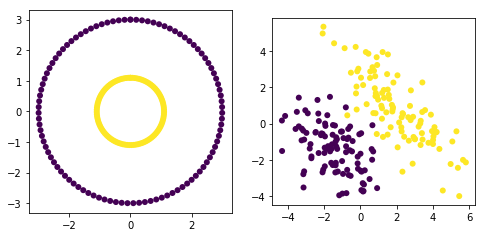

In [193]:
# Generate some data
def generate_2_circles(N=100):
    phi = np.linspace(0.0, np.pi * 2, 100)
    X1 = 1.1 * np.array([np.sin(phi), np.cos(phi)])
    X2 = 3.0 * np.array([np.sin(phi), np.cos(phi)])
    Y = np.concatenate([np.ones(N), np.zeros(N)]).reshape((-1, 1))
    X = np.hstack([X1,X2]).T
    return X, Y


def generate_2_gaussians(N=100):
    phi = np.linspace(0.0, np.pi * 2, 100)
    X1 = np.random.normal(loc=[1, 2], scale=[2.5, 0.9], size=(N, 2))
    X1 = X1.dot(np.array([[0.7, -0.7], [0.7, 0.7]]))
    X2 = np.random.normal(loc=[-2, 0], scale=[1, 1.5], size=(N, 2))
    X2 = X2.dot(np.array([[0.7, 0.7], [-0.7, 0.7]]))
    Y = np.concatenate([np.ones(N), np.zeros(N)]).reshape((-1, 1))
    X = np.vstack([X1,X2])
    return X, Y

def split(X, Y, train_ratio=0.7):
    size = len(X)
    train_size = int(size * train_ratio)
    indices = np.arange(size)
    np.random.shuffle(indices)
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    return X[train_indices], Y[train_indices], X[test_indices], Y[test_indices]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))


X, Y = generate_2_circles()
ax1.scatter(X[:,0], X[:,1], c=Y.ravel(), edgecolors= 'none')
ax1.set_aspect('equal')


X, Y = generate_2_gaussians()
ax2.scatter(X[:,0], X[:,1], c=Y.ravel(), edgecolors= 'none')
ax2.set_aspect('equal')


### Fit on gaussian data

In [194]:
X_train, Y_train, X_test, Y_test = split(*generate_2_gaussians(), 0.7)

In [195]:
# let's train our model
model = LogsticRegressionGD(2, 0.05)

for step in range(30):
    Y_pred = model.forward(X_train)
    
    loss_value = nll_forward(Y_pred, Y_train)
    accuracy = ((Y_pred > 0.5) == Y_train).mean()
    print('Step: {} \t Loss: {:.3f} \t Acc: {:.1f}%'.format(step, loss_value, accuracy * 100))
    
    loss_grad = nll_grad_input(Y_pred, Y_train)
    model.update_params(X_train, loss_grad)

    
print('\n\nTesting...')
Y_test_pred = model.forward(X_test)
test_accuracy = ((Y_test_pred > 0.5) == Y_test).mean()
print('Acc: {:.1f}%'.format(test_accuracy * 100))

Step: 0 	 Loss: 0.662 	 Acc: 65.7%
Step: 1 	 Loss: 0.627 	 Acc: 68.6%
Step: 2 	 Loss: 0.595 	 Acc: 70.7%
Step: 3 	 Loss: 0.565 	 Acc: 72.1%
Step: 4 	 Loss: 0.537 	 Acc: 72.9%
Step: 5 	 Loss: 0.512 	 Acc: 75.0%
Step: 6 	 Loss: 0.488 	 Acc: 76.4%
Step: 7 	 Loss: 0.466 	 Acc: 77.1%
Step: 8 	 Loss: 0.446 	 Acc: 79.3%
Step: 9 	 Loss: 0.427 	 Acc: 80.0%
Step: 10 	 Loss: 0.410 	 Acc: 82.9%
Step: 11 	 Loss: 0.393 	 Acc: 84.3%
Step: 12 	 Loss: 0.378 	 Acc: 84.3%
Step: 13 	 Loss: 0.364 	 Acc: 84.3%
Step: 14 	 Loss: 0.351 	 Acc: 85.7%
Step: 15 	 Loss: 0.339 	 Acc: 86.4%
Step: 16 	 Loss: 0.328 	 Acc: 87.1%
Step: 17 	 Loss: 0.318 	 Acc: 87.1%
Step: 18 	 Loss: 0.308 	 Acc: 88.6%
Step: 19 	 Loss: 0.299 	 Acc: 89.3%
Step: 20 	 Loss: 0.290 	 Acc: 90.0%
Step: 21 	 Loss: 0.282 	 Acc: 90.7%
Step: 22 	 Loss: 0.275 	 Acc: 92.1%
Step: 23 	 Loss: 0.268 	 Acc: 92.1%
Step: 24 	 Loss: 0.261 	 Acc: 92.1%
Step: 25 	 Loss: 0.255 	 Acc: 93.6%
Step: 26 	 Loss: 0.249 	 Acc: 93.6%
Step: 27 	 Loss: 0.244 	 Acc: 94.3%
St

/home/harm/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


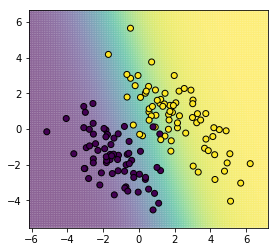

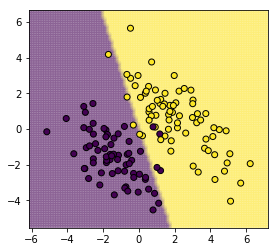

In [196]:
def plot_model_prediction(prediction_func, X, Y, hard=True):
    u_min = X[:, 0].min()-1
    u_max = X[:, 0].max()+1
    v_min = X[:, 1].min()-1
    v_max = X[:, 1].max()+1

    U, V = np.meshgrid(np.linspace(u_min, u_max, 100), np.linspace(v_min, v_max, 100))
    UV = np.stack([U.ravel(), V.ravel()]).T
    c = prediction_func(UV).ravel()
    if hard:
        c = c > 0.5
    plt.scatter(UV[:,0], UV[:,1], c=c, edgecolors= 'none', alpha=0.15)
    plt.scatter(X[:,0], X[:,1], c=Y.ravel(), edgecolors= 'black')
    plt.xlim(left=u_min, right=u_max)
    plt.ylim(bottom=v_min, top=v_max)
    plt.axes().set_aspect('equal')
    plt.show()
    
plot_model_prediction(lambda x: model.forward(x), X_train, Y_train, False)

plot_model_prediction(lambda x: model.forward(x), X_train, Y_train, True)

### Fit on circle data

In [197]:
X_train, Y_train, X_test, Y_test = split(*generate_2_circles(), 0.7)

In [198]:
# let's train our model
model = LogsticRegressionGD(2, 0.05)

for step in range(30):
    Y_pred = model.forward(X_train)
    
    loss_value = nll_forward(Y_pred, Y_train)
    accuracy = ((Y_pred > 0.5) == Y_train).mean()
    print('Step: {} \t Loss: {:.3f} \t Acc: {:.1f}%'.format(step, loss_value, accuracy * 100))
    
    loss_grad = nll_grad_input(Y_pred, Y_train)
    model.update_params(X_train, loss_grad)

    
print('\n\nTesting...')
Y_test_pred = model.forward(X_test)
test_accuracy = ((Y_test_pred > 0.5) == Y_test).mean()
print('Acc: {:.1f}%'.format(test_accuracy * 100))

Step: 0 	 Loss: 1.371 	 Acc: 49.3%
Step: 1 	 Loss: 1.357 	 Acc: 49.3%
Step: 2 	 Loss: 1.343 	 Acc: 49.3%
Step: 3 	 Loss: 1.329 	 Acc: 49.3%
Step: 4 	 Loss: 1.315 	 Acc: 49.3%
Step: 5 	 Loss: 1.301 	 Acc: 49.3%
Step: 6 	 Loss: 1.287 	 Acc: 49.3%
Step: 7 	 Loss: 1.273 	 Acc: 49.3%
Step: 8 	 Loss: 1.260 	 Acc: 49.3%
Step: 9 	 Loss: 1.246 	 Acc: 49.3%
Step: 10 	 Loss: 1.233 	 Acc: 49.3%
Step: 11 	 Loss: 1.220 	 Acc: 49.3%
Step: 12 	 Loss: 1.207 	 Acc: 49.3%
Step: 13 	 Loss: 1.194 	 Acc: 49.3%
Step: 14 	 Loss: 1.181 	 Acc: 49.3%
Step: 15 	 Loss: 1.168 	 Acc: 49.3%
Step: 16 	 Loss: 1.156 	 Acc: 49.3%
Step: 17 	 Loss: 1.144 	 Acc: 50.0%
Step: 18 	 Loss: 1.131 	 Acc: 50.0%
Step: 19 	 Loss: 1.119 	 Acc: 50.0%
Step: 20 	 Loss: 1.107 	 Acc: 50.0%
Step: 21 	 Loss: 1.096 	 Acc: 50.7%
Step: 22 	 Loss: 1.084 	 Acc: 50.7%
Step: 23 	 Loss: 1.073 	 Acc: 50.7%
Step: 24 	 Loss: 1.061 	 Acc: 50.0%
Step: 25 	 Loss: 1.050 	 Acc: 50.0%
Step: 26 	 Loss: 1.039 	 Acc: 50.0%
Step: 27 	 Loss: 1.028 	 Acc: 50.0%
St

/home/harm/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


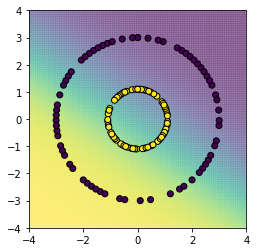

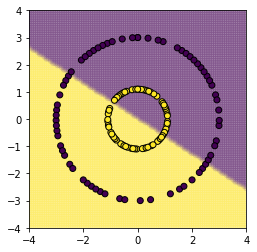

In [199]:
plot_model_prediction(lambda x: model.forward(x), X_train, Y_train, False)

plot_model_prediction(lambda x: model.forward(x), X_train, Y_train, True)

# 2. Decision Tree
The next model we look at is called **Decision Tree**. This type of model is non-parametric, meaning in contrast to **Logistic Regression** we do not have any parameters here that need to be trained.

Let us consider a simple binary decision tree for deciding on the two classes of "creditable" and "Not creditable".

![](https://mapr.com/blog/predicting-loan-credit-risk-using-apache-spark-machine-learning-random-forests/assets/blogimages/creditdecisiontree.png)

Each node, except the leafs, asks a question about the the client in question. A decision is made by going from the root node to a leaf node, while considering the clients situation. The situation of the client, in this case, is fully described by the features:
1. Checking account balance
2. Duration of requested credit
3. Payment status of previous loan
4. Length of current employment

In order to build a decision tree we need training data. To carry on the previous example: we need a number of clients for which we know the properties 1.-4. and their creditability.
The process of building a decision tree starts with the root node and involves the following steps:
1. Choose a splitting criteria and add it to the current node.
2. Split the dataset at the current node into those that fullfil the criteria and those that do not.
3. Add a child node for each data split.
4. For each child node decide on either A. or B.:
    1. Repeat from 1. step
    2. Make it a leaf node: The predicted class label is decided by the majority vote over the training data in the current split.

## 2.1 Gini Index & Data Split
Deciding on how to split your training data at each node is dominated by the following two criterias:
1. Does the rule help me make a final decision?
2. Is the rule general enough such that it applies not only to my training data, but also to new unseen examples?

When considering our previous example, splitting the clients by their handedness would not help us deciding on their creditability. Knowning if a rule will generalize is usually a hard call to make, but in practice we rely on [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor) principle. Thus the less rules we use, the better we believe it to generalize to previously unseen examples.

One way to measure the quality of a rule is by the [**Gini Index**](https://en.wikipedia.org/wiki/Gini_coefficient).
Since we only consider binary classification, it is calculated by:
$$
Gini = \sum_{n\in\{L,R\}}\frac{|S_n|}{|S|}\left( 1 - \sum_{c \in C} p_{S_n}(c)^2\right)\\
p_{S_n}(c) = \frac{|\{\mathbf{x}_{i}\in \mathbf{X}|y_{i} = c, i \in S_n\}|}{|S_n|}, n \in \{L, R\}
$$
with $|C|=2$ being your set of class labels and $S_L$ and $S_R$ the two splits determined by the splitting 
criteria.
The lower the gini score, the better the split. In the extreme case, where all class labels are the same in each split respectively, the gini index takes the value of $0$.

In [216]:
def tree_gini_index(Y_left, Y_right, classes):
    """Compute the Gini Index.
    # Arguments
        Y_left: class labels of the data left set
            np.array of size `(n_objects, 1)`
        Y_right: class labels of the data right set
            np.array of size `(n_objects, 1)`
        classes: list of all class values
    # Output
        gini: scalar `float`
    """
    Splits = (Y_left, Y_right)
    T_len = np.sum([len(S) for S in Splits])

    gini = 0.0
    for S in Splits:
        p_sum = 0.0
        for c in classes:
            p = np.sum(np.array(S) == c) / len(S)
            p_sum += p**2
        gini += len(S) / T_len * (1 - p_sum)

    return gini

In [217]:
am.test_student_function(username, tree_gini_index, ['Y_left', 'Y_right', 'classes'])

Running local tests...
tree_gini_index successfully passed local tests
Running remote test...
Test was successful. Congratulations!


At each node in the tree, the data is split according to a split criterion and each split is passed onto the left/right child respectively.
Implement the following function to return all rows in `X` and `Y` such that the left child gets all examples that are less than the split value and vice versa. 

In [248]:
def tree_split_data_left(X, Y, feature_index, split_value):
    """Split the data `X` and `Y`, at the feature indexed by `feature_index`.
    If the value is less than `split_value` then return it as part of the left group.
    
    # Arguments
        X: np.array of size `(n_objects, n_in)`
        Y: np.array of size `(n_objects, 1)`
        feature_index: index of the feature to split at 
        split_value: value to split between
    # Output
        (XY_left): np.array of size `(n_objects_left, n_in + 1)`
    """
    assert(feature_index <= np.shape(X)[1])
    assert(feature_index >= 0)
    
    Z = np.append(X,Y, axis=1)
    return Z[Z[:,feature_index] < split_value]

def tree_split_data_right(X, Y, feature_index, split_value):
    """Split the data `X` and `Y`, at the feature indexed by `feature_index`.
    If the value is greater or equal than `split_value` then return it as part of the right group.
    
    # Arguments
        X: np.array of size `(n_objects, n_in)`
        Y: np.array of size `(n_objects, 1)`
        feature_index: index of the feature to split at
        split_value: value to split between
    # Output
        (XY_left): np.array of size `(n_objects_left, n_in + 1)`
    """
    assert(feature_index <= np.shape(X)[1])
    assert(feature_index >= 0)
    
    Z = np.append(X,Y, axis=1)
    return Z[Z[:,feature_index] >= split_value]

In [246]:
X = np.array([[ 4.44443155,  9.84755411],
             [ 0.87669203,  0.23400127],
             [ 6.93641601, -3.14280346],
             [ 4.54863768,  5.0348375 ],
             [-1.14587177, -2.46124326],
             [-6.47480422, -4.74631328],
             [-3.16880904,  3.71041515],
             [ 4.74583194, -1.22801333],
             [-6.37401965,  8.73366778]])

Y = [[1.], [0.], [0.], [1.], [0.], [0.], [1.], [0.], [0.]]
feature_index = 1
split_value = -1.1136209970632827

tree_split_data_left(X, Y, feature_index, split_value)

[[ 6.93641601 -3.14280346  0.        ]
 [-1.14587177 -2.46124326  0.        ]
 [-6.47480422 -4.74631328  0.        ]
 [ 4.74583194 -1.22801333  0.        ]]


In [249]:
call30(am.test_student_function, (username, tree_split_data_left, ['X', 'Y', 'feature_index', 'split_value']))

Running local tests...
tree_split_data_left successfully passed local tests
Running remote test...
Test was successful. Congratulations!


In [251]:
call30(am.test_student_function, (username, tree_split_data_right, ['X', 'Y', 'feature_index', 'split_value']))

Running local tests...
tree_split_data_right successfully passed local tests
Running remote test...
Test was successful. Congratulations!


In [252]:
am.get_progress(username)

---------------------------------------------
| Harm Manders                              |
| harmmanders@gmail.com                     |
---------------------------------------------
| W2: linear_forward       | completed      |
| W2: linear_grad_W        | completed      |
| W2: linear_grad_b        | completed      |
| W2: nll_forward          | completed      |
| W2: nll_grad_input       | completed      |
| W2: sigmoid_forward      | completed      |
| W2: sigmoid_grad_input   | completed      |
| W2: tree_gini_index      | completed      |
| W2: tree_split_data_left | completed      |
| W2: tree_split_data_right| completed      |
| W2: tree_to_terminal     | not attempted  |
| W3: box_blur             | not attempted  |
| W3: conv_matrix          | not attempted  |
| W3: dense_forward        | not attempted  |
| W3: dense_grad_W         | not attempted  |
| W3: dense_grad_b         | not attempted  |
| W3: dense_grad_input     | not attempted  |
| W3: flatten_forward      | not a

Now to find the split rule with the lowest gini score, we brute-force search over all features and values to split by.

In [253]:
def tree_best_split(X, Y):
    class_values = list(set(Y.flatten().tolist()))
    r_index, r_value, r_score =  float("inf"),  float("inf"), float("inf")
    r_XY_left, r_XY_right = (X,Y), (X,Y)
    for feature_index in range(X.shape[1]):
        for row in X:
            XY_left = tree_split_data_left(X, Y, feature_index, row[feature_index])
            XY_right = tree_split_data_right(X, Y, feature_index, row[feature_index])
            XY_left, XY_right = (XY_left[:,:-1], XY_left[:,-1:]), (XY_right[:,:-1], XY_right[:,-1:])
            gini = tree_gini_index(XY_left[1], XY_right[1], class_values)
            if gini < r_score:
                r_index, r_value, r_score = feature_index, row[feature_index], gini
                r_XY_left, r_XY_right = XY_left, XY_right
    return {'index':r_index, 'value':r_value, 'XY_left': r_XY_left, 'XY_right':r_XY_right}

## 2.2 Terminal Node
The leaf nodes predict the label of an unseen example, by taking a majority vote over all training class labels in that node.

In [288]:
def tree_to_terminal(Y):
    """The most frequent class label, out of the data points belonging to the leaf node,
    is selected as the predicted class.
    
    # Arguments
        Y: np.array of size `(n_objects)`
        
    # Output
        label: most frequent label of `Y.dtype`
    """
    counts = np.asarray(np.unique(Y, return_counts=True))
    return counts[0, np.argmax(counts[1])]


In [289]:
call30(am.test_student_function, (username, tree_to_terminal, ['Y']))

Running local tests...
tree_to_terminal successfully passed local tests
Running remote test...
Test was successful. Congratulations!


In [290]:
am.get_progress(username)

---------------------------------------------
| Harm Manders                              |
| harmmanders@gmail.com                     |
---------------------------------------------
| W2: linear_forward       | completed      |
| W2: linear_grad_W        | completed      |
| W2: linear_grad_b        | completed      |
| W2: nll_forward          | completed      |
| W2: nll_grad_input       | completed      |
| W2: sigmoid_forward      | completed      |
| W2: sigmoid_grad_input   | completed      |
| W2: tree_gini_index      | completed      |
| W2: tree_split_data_left | completed      |
| W2: tree_split_data_right| completed      |
| W2: tree_to_terminal     | completed      |
| W3: box_blur             | not attempted  |
| W3: conv_matrix          | not attempted  |
| W3: dense_forward        | not attempted  |
| W3: dense_grad_W         | not attempted  |
| W3: dense_grad_b         | not attempted  |
| W3: dense_grad_input     | not attempted  |
| W3: flatten_forward      | not a

## 2.3 Build the Decision Tree
Now we recursively build the decision tree, by greedily splitting the data at each node according to the gini index.
To prevent the model from overfitting, we transform a node into a terminal/leaf node, if:
1. a maximum depth is reached.
2. the node does not reach a minimum number of training samples.


In [291]:
def tree_recursive_split(X, Y, node, max_depth, min_size, depth):
    XY_left, XY_right = node['XY_left'], node['XY_right']
    del(node['XY_left'])
    del(node['XY_right'])
    # check for a no split
    if XY_left[0].size <= 0 or XY_right[0].size <= 0:
        node['left_child'] = node['right_child'] = tree_to_terminal(np.concatenate((XY_left[1], XY_right[1])))
        return
    # check for max depth
    if depth >= max_depth:
        node['left_child'], node['right_child'] = tree_to_terminal(XY_left[1]), tree_to_terminal(XY_right[1])
        return
    # process left child
    if XY_left[0].shape[0] <= min_size:
        node['left_child'] = tree_to_terminal(XY_left[1])
    else:
        node['left_child'] = tree_best_split(*XY_left)
        tree_recursive_split(X, Y, node['left_child'], max_depth, min_size, depth+1)
    # process right child
    if XY_right[0].shape[0] <= min_size:
        node['right_child'] = tree_to_terminal(XY_right[1])
    else:
        node['right_child'] = tree_best_split(*XY_right)
        tree_recursive_split(X, Y, node['right_child'], max_depth, min_size, depth+1)


def build_tree(X, Y, max_depth, min_size):
    root = tree_best_split(X, Y)
    tree_recursive_split(X, Y, root, max_depth, min_size, 1)
    return root

By printing the split criteria or the predicted class at each node, we can visualise the decising making process.
Both the tree and a a prediction can be implemented recursively, by going from the root to a leaf node.

In [292]:
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
        print_tree(node['left_child'], depth+1)
        print_tree(node['right_child'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))
        
def tree_predict_single(x, node):
    if isinstance(node, dict):
        if x[node['index']] < node['value']:
            return tree_predict_single(x, node['left_child'])
        else:
            return tree_predict_single(x, node['right_child'])
        
    return node

def tree_predict_multi(X, node):
    Y = np.array([tree_predict_single(row, node) for row in X])
    return Y[:, None]  # size: (n_object,) -> (n_object, 1)

Let's test our decision tree model on some toy data.

In [293]:
X_train, Y_train, X_test, Y_test = split(*generate_2_circles(), 0.7)

tree = build_tree(X_train, Y_train, 4, 1)
Y_pred = tree_predict_multi(X_test, tree)
test_accuracy = (Y_pred == Y_test).mean()
print('Test Acc: {:.1f}%'.format(test_accuracy * 100))

Test Acc: 100.0%


/home/harm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars


We print the decision tree in [pre-order](https://en.wikipedia.org/wiki/Tree_traversal#Pre-order_(NLR)).

In [294]:
print_tree(tree)

[X2 < -1.099]
 [X1 < 0.474]
  [X1 < -2.598]
   [0.0]
   [X1 < -1.203]
    [0.0]
    [0.0]
  [X1 < 1.375]
   [X1 < 1.203]
    [0.0]
    [0.0]
   [X1 < 2.688]
    [0.0]
    [0.0]
 [X2 < 1.246]
  [X1 < 2.802]
   [X1 < -1.100]
    [0.0]
    [1.0]
   [X1 < 2.936]
    [0.0]
    [0.0]
  [X1 < -2.444]
   [X1 < -2.549]
    [0.0]
    [0.0]
   [X1 < -1.115]
    [0.0]
    [0.0]


/home/harm/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


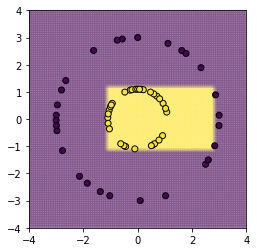

In [295]:
plot_model_prediction(lambda x: tree_predict_multi(x, tree), X_test, Y_test)

# 3. Experiments
The [Cleveland Heart Disease](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) dataset aims at predicting the presence of heart disease based on other available medical information of the patient.

Although the whole database contains 76 attributes, we focus on the following 14:
1. Age: age in years 
2. Sex: 
    * 0 = female
    * 1 = male 
3. Chest pain type: 
    * 1 = typical angina
    * 2 = atypical angina
    * 3 = non-anginal pain
    * 4 = asymptomatic
4. Trestbps: resting blood pressure in mm Hg on admission to the hospital 
5. Chol: serum cholestoral in mg/dl 
6. Fasting blood sugar: > 120 mg/dl
    * 0 = false
    * 1 = true
7. Resting electrocardiographic results: 
    * 0 = normal
    * 1 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) 
    * 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria 
8. Thalach: maximum heart rate achieved 
9. Exercise induced angina:
    * 0 = no
    * 1 = yes
10. Oldpeak: ST depression induced by exercise relative to rest 
11. Slope: the slope of the peak exercise ST segment
    * 1 = upsloping
    * 2 = flat 
    * 3 = downsloping 
12. Ca: number of major vessels (0-3) colored by flourosopy 
13. Thal: 
    * 3 = normal
    * 6 = fixed defect
    * 7 = reversable defect 
14. Target: diagnosis of heart disease (angiographic disease status)
    * 0 = < 50% diameter narrowing 
    * 1 = > 50% diameter narrowing
    
The 14. attribute is the target variable that we would like to predict based on the rest.

We have prepared some helper functions to download and pre-process the data in `heart_disease_data.py`

In [296]:
import heart_disease_data

In [297]:
X, Y = heart_disease_data.download_and_preprocess()
X_train, Y_train, X_test, Y_test = split(X, Y, 0.7)

Let's have a look at some examples

In [298]:
print(X_train[0:2])
print(Y_train[0:2])

# TODO feel free to explore more examples and see if you can predict the presence of a heart disease

[[ 71.    0.    4.  112.  149.    0.    0.  125.    0.    1.6   2.    0.
    3. ]
 [ 60.    1.    4.  130.  206.    0.    2.  132.    1.    2.4   2.    2.
    7. ]]
[[0.]
 [1.]]


## 3.1 Decision Tree for Heart Disease Prediction 
Let's build a decision tree model on the training data and see how well it performs

In [299]:
# TODO: you are free to make use of code that we provide in previous cells
# TODO: play around with different hyper parameters and see how these impact your performance

tree = build_tree(X_train, Y_train, 5, 4)
Y_pred = tree_predict_multi(X_test, tree)
test_accuracy = (Y_pred == Y_test).mean()
print('Test Acc: {:.1f}%'.format(test_accuracy * 100))

/home/harm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars


Test Acc: 81.1%


How did changing the hyper parameters affect the test performance? Usually hyper parameters are tuned using a hold-out [validation set](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets#Validation_dataset) instead of the test set.

## 3.2 Logistic Regression for Heart Disease Prediction

Instead of manually going through the data to find possible correlations, let's try training a logistic regression model on the data.

In [ ]:
# TODO: you are free to make use of code that we provide in previous cells
# TODO: play around with different hyper parameters and see how these impact your performance

How well did your model perform? Was it actually better then guessing? Let's look at the empirical mean of the target.

In [ ]:
Y_train.mean()

So what is the problem? Let's have a look at the learned parameters of our model.

In [ ]:
print(model.W, model.b)

If you trained sufficiently many steps you'll probably see how some weights are much larger than others. Have a look at what range the parameters were initialized and how much change we allow per step (learning rate). Compare this to the scale of the input features. Here an important concept arises, when we want to train on real world data: 
[Feature Scaling](https://en.wikipedia.org/wiki/Feature_scaling).

Let's try applying it on our data and see how it affects our performance.

In [ ]:
# TODO: Rescale the input features and train again

Notice that we did not need any rescaling for the decision tree. Can you think of why?